In [1]:
from tabula.io import read_pdf
import pandas as pd
import numpy as np

In [29]:
# Replace 'bank_statement.pdf' with the actual path to your PDF file
pdf_file_path = "C://Users//bank_statement.pdf"

#This is the password to the MPESA document. If the file is already decrypted you can ignore this 
#password = "223245"

In [30]:
def data_cleaning(data_frame):
    # Dropping the unnecessary columns
    data_frame = data_frame.drop(data_frame.columns[7:], axis=1)
    data_frame = data_frame.drop(data_frame.columns[[3]], axis=1)
    #Dropping NA rows in the receipt no. column
    data_frame = data_frame.dropna(subset="Receipt No.")
    #converting completion time to date object
    data_frame["Completion Time"] = pd.to_datetime(data_frame["Completion Time"]).dt.normalize()
    #replacing \r in the details column with space
    data_frame["Details"] =  data_frame["Details"].str.replace(r"\r"," ",regex=True)
    #replacing the minus sign in the withdrawn column
    data_frame["Withdrawn"] = data_frame["Withdrawn"].str.replace("-","")
    cols=["Paid In","Withdrawn","Balance"]
    data_frame[cols]= data_frame[cols].replace(",","",regex=True)
    #converting NAN to zero
    data_frame= data_frame.fillna(0)
    data_frame[cols] = data_frame[cols].apply(pd.to_numeric,axis=1)
    data_frame = data_frame.reindex(index=data_frame.index[::-1])

    return data_frame

In [31]:
def extract_tables_from_pdf(pdf_file):
    # Read the tables from the PDF file
    tables = read_pdf(pdf_file, pages="all", multiple_tables=True)
    
    #if the file is not yet decrypted use this instead
    #tables = tabula.read_pdf(pdf_file,pages = "all", multiple_tables=True, password= password)

    # Combine all tables except the first one into a single DataFrame
    # We start at table 2 to ignore the summary tables
    combined_df = pd.concat(tables[2:], ignore_index=True)
    combined_df = data_cleaning(combined_df)
    return combined_df

In [ ]:
combined_data_frame = extract_tables_from_pdf(pdf_file_path)
combined_data_frame.head()

In [33]:
combined_data_frame.dtypes

Receipt No.                object
Completion Time    datetime64[ns]
Details                    object
Paid In                   float64
Withdrawn                 float64
Balance                   float64
dtype: object

In [34]:
#Categorisation of transactions
categories = {
    "Income":["Funds received from ","Deposit of Funds at Agent Till "],
    "Contra entry" : ["Business Payment from ","Salary Payment from "],
    "Loan" : ["OverDraft of Credit Party","KCB M-PESA Withdraw","M-Shwari Withdraw","M-Shwari Loan Disburse"],
    "Airtime" : ["Airtime Purchase ","Airtime Purchase"],
    "Bundles" : ["Buy Bundles "],
    "Loan repayment" : ["OD Loan Repayment to 232323 - M-PESA Overdraw","M-Shwari Loan Repayment"],
    "Transaction charges" : ["Charge"],
    "Expenses" : ["Pay Bill to ","Pay Bill Online to ","Pay Bill Fuliza ","Customer Payment to Small Business to ",
                  "Customer Transfer Fuliza MPesa to ","Merchant Payment to ","Customer Transfer to "],
    "Agent withdrawals" : ["Customer Withdrawal At Agent Till "]
}


In [35]:
def transaction_categorisation(df,category):
    words = []
    mapping_dict = {}

    for i,j in category.items():
        for item in j:
            words.append(item)
            mapping_dict[item] = i

    joined_text = df["Details"].str.extract(f"({'|'.join(words)})")
    text_category = joined_text[0].map(mapping_dict)
    text_category = text_category.fillna("Others")
    return text_category

In [ ]:
transaction_categories = transaction_categorisation(combined_data_frame,categories)
combined_data_frame["Transaction Categories"]=transaction_categories

#combined_data_frame.insert(3,"Transaction Categories",transaction_categories)
combined_data_frame.head()

In [37]:
#Calculation of DTI
total_deposits = combined_data_frame["Paid In"].sum()
total_withdrawals = combined_data_frame["Withdrawn"].sum()
contra_entry_credits = combined_data_frame.loc[combined_data_frame["Transaction Categories"] =="Contra entry","Paid In"].sum()
contra_entry_debits = combined_data_frame.loc[combined_data_frame["Transaction Categories"] =="Contra entry","Withdrawn"].sum()
net_amount = total_deposits - contra_entry_credits
average_monthly_credits = net_amount/((combined_data_frame["Completion Time"].iloc[0] - combined_data_frame["Completion Time"].iloc[-1])/np.timedelta64("1","M"))
business_dti = average_monthly_credits * 0.10

In [38]:
# #Creating dataframe of dates and balances
def calculate_daily_balances(dataframe):

    unique_dates = dataframe["Completion Time"].unique()
    daily_dates = pd.date_range(start=dataframe["Completion Time"].min(),
                                 end=dataframe["Completion Time"].max(),freq="D")

    cols = ["Completion Time","Balance"]
    daily_balances = dataframe[cols].copy()
    daily_balances = daily_balances.drop_duplicates("Completion Time",keep="last")
    daily_balances = daily_balances.set_index("Completion Time",drop=False)

    if len(unique_dates) != len(daily_dates):
        daily_balances = daily_balances.resample("D").asfreq().fillna(method="ffill")
        return daily_balances

    else:
        return daily_balances

In [39]:
latest_running_balance = calculate_daily_balances(combined_data_frame)
latest_running_balance.head()

,Completion Time,Balance
Completion Time,,
2023-02-16,2023-02-16,21430.02
2023-02-17,2023-02-17,95885.02
2023-02-18,2023-02-18,16359.02
2023-02-19,2023-02-19,14049.02
2023-02-20,2023-02-20,73.52


In [40]:
monthly_transactions = combined_data_frame.resample(rule="M",on="Completion Time").sum()
monthly_transactions = monthly_transactions.drop("Balance",axis=1)
monthly_transactions

C:\Users\bogge\AppData\Local\Temp\ipykernel_15320\687729859.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,Paid In,Withdrawn
Completion Time,,
2023-02-28,1162121.0,1101231.00
2023-03-31,3468817.0,3534704.95
2023-04-30,3649738.0,3648510.50
2023-05-31,3746806.0,3760828.90
2023-06-30,4986255.0,4986397.00
2023-07-31,3586468.0,3740236.50
2023-08-31,2071777.0,1930612.50


In [81]:
#Smoothing using the Exponential Moving Average
alpha = 2/(1+4)
latest_running_balance["EMA"] = latest_running_balance["Balance"].ewm(alpha=alpha,adjust=True).mean()
latest_running_balance.head()

,Completion Time,Balance,EMA
Completion Time,,,
2023-02-16,2023-02-16,21430.02,21430.020000
2023-02-17,2023-02-17,95885.02,67964.395000
2023-02-18,2023-02-18,16359.02,41635.122041
2023-02-19,2023-02-19,14049.02,28957.685441
2023-02-20,2023-02-20,73.52,16429.855184


In [82]:
# import hvplot.pandas
# import plotly.express as px
# import panel as pn
# import datetime as dt
# 
# if "data" not in pn.state.cache.keys():
#     pn.state.cache["data"] = latest_running_balance.copy()
# else:
#     latest_running_balance = pn.state.cache["data"]
#     
# interactive_running_balance = latest_running_balance.interactive()
# 
# start_date = latest_running_balance["Completion Time"].min()
# end_date = latest_running_balance['Completion Time'].max()
# 
# initial_value = (start_date, end_date)
# 
# month_slider = pn.widgets.DateRangeSlider(
#     name = "Month Slider",
#     start = start_date,
#     end=end_date,
#     value=initial_value
#     
#     )
# 
# month_slider
# 
# @pn.depends(month_slider.param.value)
# def create_balance_plot(date_range):
#     start_date, end_date = date_range
#     filtered_data = latest_running_balance[
#         (latest_running_balance['Completion Time'] >= start_date) &
#         (latest_running_balance['Completion Time'] <= end_date)
#     ] 
#      
#     running_balance_graph = filtered_data.hvplot.line(
#         x="Completion Time",
#         y=["Balance", "EMA"],
#         size=50
#     ).opts(
#         title="Running balance between {} and {}".format(start_date, end_date),
#         xlabel="Months",
#         ylabel="Amount in KES"
#     )
#     
#     return running_balance_graph
# 
# dashboard = pn.Column(
#     month_slider,
#     create_balance_plot
# )
# dashboard

#Creating a dashboard
#Graph of expenditure
#Graph of number of expenditure
#Recurring transactions
#Table of bank movements
#Text of DTI, outstanding loans and possible 

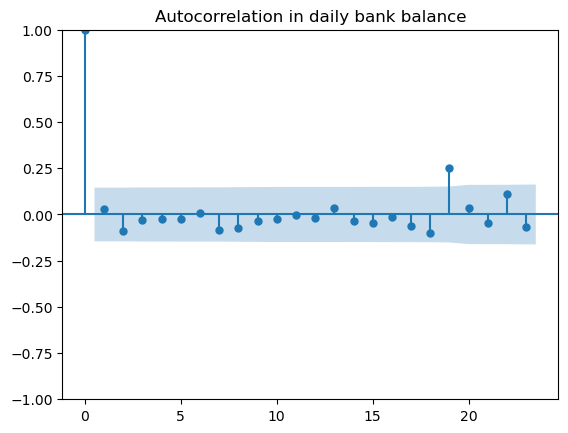

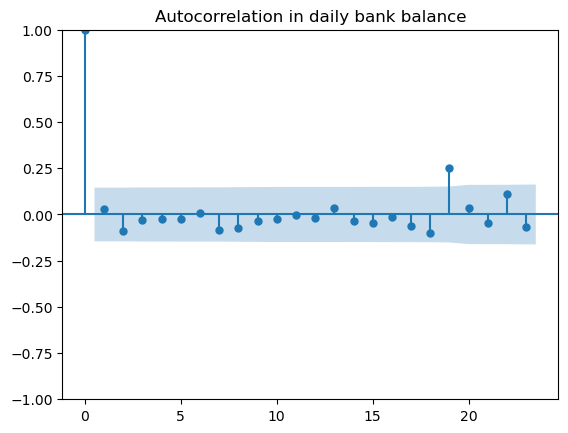

In [83]:
#Forecasting the bank balance using ARIMA
#Checking the stationarity of the data using ACF plot and Augmented Dickey-Fuller Test
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(
    x=latest_running_balance["Balance"],
    alpha=0.05,
    title="Autocorrelation in daily bank balance")



In [116]:
from arch.unitroot import ADF
series = latest_running_balance["EMA"].diff().dropna()
adf = ADF(series)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -8.970
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


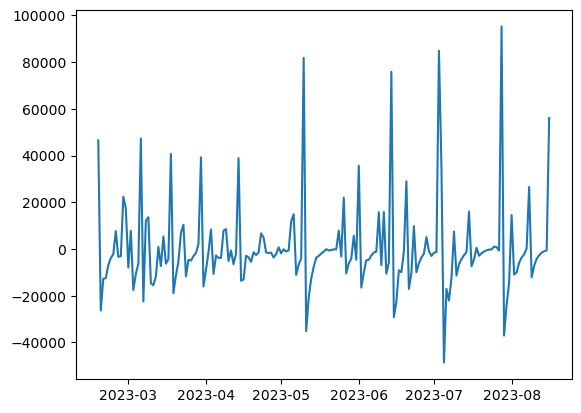

In [117]:
from matplotlib import pyplot
pyplot.plot(series)

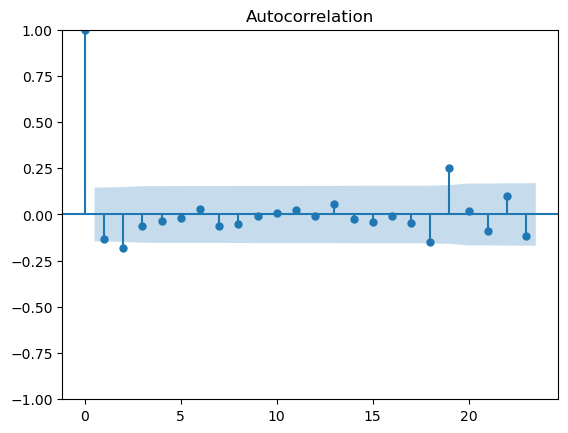

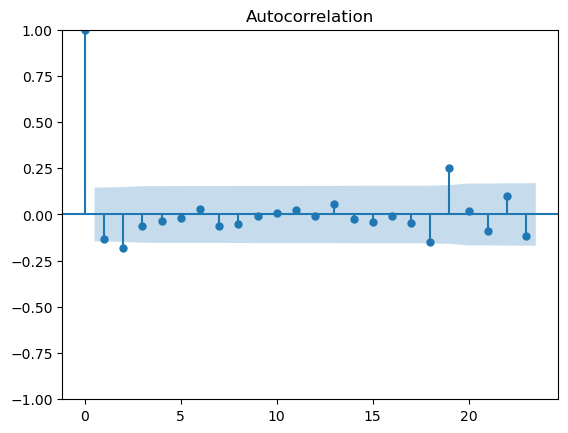

In [118]:
plot_acf(
    x=series,
    alpha=0.05
)

In [119]:
#!pip install pmdarima

In [120]:
from  pmdarima import auto_arima

arima_balance = auto_arima(
    series,
    start_p=1,
    d=1,
    start_q =1,
    start_P=1,
    D=1,
    start_Q=1,
    stepwise=True,
    stationary=True,
    seasonal=False,
    trace=True
)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4082.121, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4080.694, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4077.467, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4080.140, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4054.530, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=4057.344, Time=0.38 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=4055.492, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.19 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 2.409 seconds


In [132]:
#Splitting the data to training and testing data
ratio = 0.8
df_rows = series.shape[0]
train_size = int(df_rows * ratio)
train = series[0:train_size]
test = series[train_size:]
test.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 37 entries, 2023-07-11 to 2023-08-16
Series name: EMA
Non-Null Count  Dtype  
--------------  -----  
37 non-null     float64
dtypes: float64(1)
memory usage: 592.0 bytes


In [133]:
arima_balance.fit(train)
future_predictions = arima_balance.predict(len(test))

future_predictions_df = pd.DataFrame(
    future_predictions,
    index = test.index,
    columns=['Predictions']
) 
print(future_predictions)

2023-07-11    5965.534334
2023-07-12    6323.757886
2023-07-13    2317.668449
2023-07-14     960.559238
2023-07-15     500.822769
2023-07-16     345.081714
2023-07-17     292.322627
2023-07-18     274.449875
2023-07-19     268.395274
2023-07-20     266.344207
2023-07-21     265.649385
2023-07-22     265.414005
2023-07-23     265.334268
2023-07-24     265.307256
2023-07-25     265.298105
2023-07-26     265.295005
2023-07-27     265.293955
2023-07-28     265.293600
2023-07-29     265.293479
2023-07-30     265.293438
2023-07-31     265.293424
2023-08-01     265.293420
2023-08-02     265.293418
2023-08-03     265.293418
2023-08-04     265.293417
2023-08-05     265.293417
2023-08-06     265.293417
2023-08-07     265.293417
2023-08-08     265.293417
2023-08-09     265.293417
2023-08-10     265.293417
2023-08-11     265.293417
2023-08-12     265.293417
2023-08-13     265.293417
2023-08-14     265.293417
2023-08-15     265.293417
2023-08-16     265.293417
Freq: D, dtype: float64


In [134]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

pd.concat([test,future_predictions],axis=1).iplot()

In [135]:
#Calculating the MSE

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test,future_predictions)
print(f"The mean squared error is",mse)

The mean squared error is 443341288.0546978


**ARIMA** is not an appropriate model for predicting bank balances.